In [174]:
import numpy as np
import pandas as pd
# import scipy
import matplotlib as plt


import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
plt.style.use("../KD_style.mplstyle")


In [40]:


def load_and_inspect_data(path, test_size = 0.2, compare_exists = True, sep = "\s+", auto_select_X_variables = True, auto_select_threshold = 0.2):
    data = pd.read_csv(path, sep = sep)
    
    corr = data.corr()
    corr_rank_df = pd.concat([corr.iloc[-1][:-1].abs().rank(ascending=False), corr.iloc[-1][:-1]], axis = 1, keys = ["rank", "corr"]).sort_values(by = "rank")
    print(corr_rank_df)
    
    if auto_select_X_variables:
        good_variables = corr_rank_df.index[corr_rank_df["corr"].values > auto_select_threshold].to_numpy()
        data = pd.concat([data[good_variables], data.iloc[:,-1]], axis = 1)
        
    if compare_exists:
        compare = data.iloc[:,-2]
        y = data.iloc[:,-1]
        X = data.iloc[:,:-2]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size)
        return X_train, X_test, y_train, y_test, compare
    else:
        X = data.iloc[:,:-1]
        y = data.iloc[:,-1]
    
    

X_train, X_test, y_train, y_test, compare = load_and_inspect_data("../Week1/AlephBtag_MC_train_Nev5000.csv")

        rank      corr
nnbjet   1.0  0.735625
prob_b   2.0  0.651354
bqvjet   3.0  0.563827
ptlrel   4.0  0.299047
spheri   5.0  0.278414
multip   6.0  0.229967
energy   7.0 -0.188039
phi      8.0 -0.009310
pt2rel   9.0  0.000299
cTheta  10.0  0.000025


In [146]:
# train_data = lgb.Dataset(pd.concat([X_train,y_train], axis = 1))
# val_data = lgb.Dataset(pd.concat([X_test,y_test], axis = 1))

params_lgb = {
    # "num_leaves" : 100,
    # "max_depth": 30,
    "min_child_samples":300,
    # 'objective': 'binary',
    # "n_estimators":100,
    # "learning_rate":0.1
    }
# SKlearn API in lightGBM https://lightgbm.readthedocs.io/en/v3.3.5/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
lbgt = lgb.LGBMClassifier(**params_lgb)

lbgt.fit(X_train, y_train)


0.92
0.898


1188    0.4793
4928    0.5680
4614    0.3921
4840    0.4639
3003    0.4840
         ...  
3156    0.3562
2130    0.5117
2425    0.2608
3599    0.1464
2298    0.3094
Name: multip, Length: 1000, dtype: float64
1188    0
4928    0
4614    0
4840    0
3003    0
       ..
3156    0
2130    0
2425    1
3599    0
2298    0
Name: isb, Length: 1000, dtype: int64


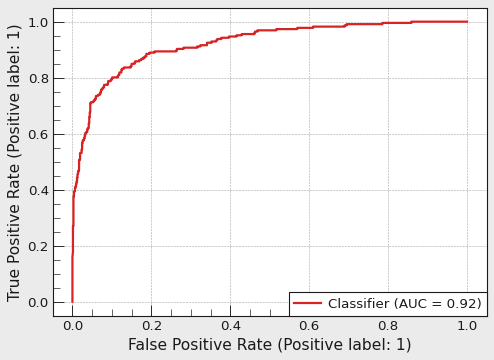

In [177]:
y_pred_lgb = lbgt.predict_proba(X_test).T[1]
lgb_auc = roc_auc_score(y_test, y_pred_lgb)
RocCurveDisplay.from_predictions(y_test, y_pred_lgb)
# RocCurveDisplay.from_predictions(y_test, compare.iloc[y_test.index])
print(compare.iloc[y_test.index])
print(y_test)

In [159]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# https://xgboost.readthedocs.io/en/stable/treemethod.html
xgbt = xgb.XGBClassifier(max_depth = 3, n_estimators = 100, booster = "gbtree")
xgbt.fit(X_train, y_train)
y_pred_xgb = xgbt.predict(X_test)

0.935
0.892


In [ ]:
roc